<a href="https://colab.research.google.com/github/DayaAlex/CV-Object_Localisation/blob/main/Object_Localization_on_custom_dataset_implemented_in_Pytorch_on_colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Intro Task, Object Localization 

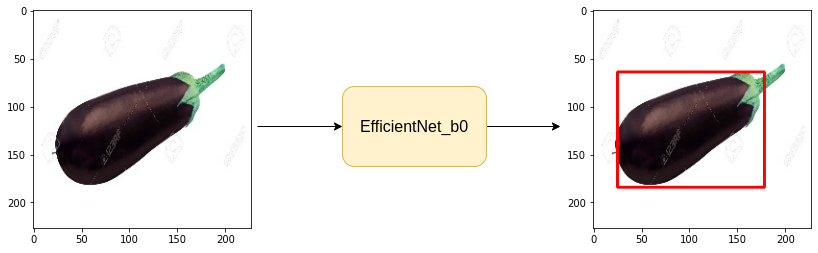

In [1]:
# install libraries/packages/modules 

!pip install -U git+https://github.com/albumentations-team/albumentations
!pip install timm
!pip install --upgrade opencv-contrib-python

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/albumentations-team/albumentations to /tmp/pip-req-build-64didn4c
  Running command git clone --filter=blob:none --quiet https://github.com/albumentations-team/albumentations /tmp/pip-req-build-64didn4c
  Resolved https://github.com/albumentations-team/albumentations to commit b773a1aa69f9c823c7f593205614d05d32c039cb
  Preparing metadata (setup.py) ... done
  Created wheel for albumentations: filename=albumentations-1.3.0-py3-none-any.whl size=125709 sha256=b25e6914147d6a05951414f2bbeb4a13412397bc3ae92de92fb0646b04d51b40
  Stored in directory: /tmp/pip-ephem-wheel-cache-3e0uj51y/wheels/6d/72/93/d30af2a1f90e7c7e811e8fa43aa723971c91af45052ffa1b5a
Successfully built albumentations
  Attempting uninstall: albumentations
    Found existing installation: albumentations 1.2.1
    Uninstalling albumentations-1.2.1:
      Successfully uninstalled albumentations-1.2.1
L

In [2]:
# Download Dataset

!git clone https://github.com/parth1620/object-localization-dataset.git

Cloning into 'object-localization-dataset'...
remote: Enumerating objects: 203, done.
remote: Counting objects: 100% (203/203), done.
remote: Compressing objects: 100% (203/203), done.
remote: Total 203 (delta 3), reused 195 (delta 0), pack-reused 0
Receiving objects: 100% (203/203), 2.73 MiB | 10.69 MiB/s, done.
Resolving deltas: 100% (3/3), done.


In [3]:
import pandas as pd 
import numpy as np 
import cv2
import matplotlib.pyplot as plt
import torch
from tqdm.notebook import tqdm

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

In [4]:
import sys
sys.path.append('/content/object-localization-dataset')

# Configurations

In [5]:
CSV_FILE='/content/object-localization-dataset/train.csv'
DATA_DIR='/content/object-localization-dataset/'
BATCH_SIZE=16
IMG_SIZE=140

DEVICE='cuda'
LR=0.001
EPOCHS=40
MODEL_NAME='efficientnet_b0'

NUM_COR= 4

In [6]:
df=  pd.read_csv(CSV_FILE)
df 

,img_path,xmin,ymin,xmax,ymax,width,height,label
0,train_images/mushroom_51.jpg,24,23,202,183,227,227,mushroom
1,train_images/eggplant_37.jpg,34,34,88,201,227,227,eggplant
2,train_images/mushroom_20.jpg,49,86,183,185,227,227,mushroom
3,train_images/eggplant_51.jpg,51,59,191,164,227,227,eggplant
4,train_images/eggplant_26.jpg,40,70,179,168,227,227,eggplant
...,...,...,...,...,...,...,...,...
181,train_images/eggplant_62.jpg,67,22,177,215,227,227,eggplant
182,train_images/cucumber_45.jpg,11,31,217,208,227,227,cucumber
183,train_images/mushroom_37.jpg,93,13,158,193,227,227,mushroom
184,train_images/eggplant_44.jpg,21,59,192,171,227,227,eggplant


# Understand the dataset

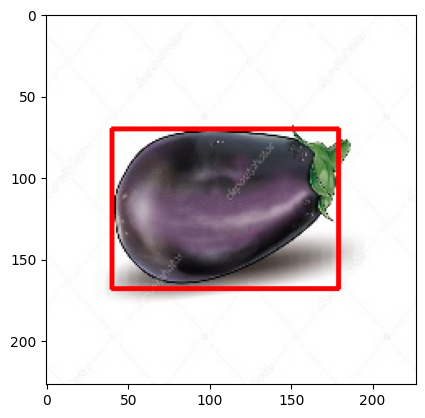

In [25]:
row = df.iloc[4]
img =cv2.imread(DATA_DIR + row.img_path)
img =cv2.cvtColor(img,cv2.COLOR_BGR2RGB)

pt1=(row.xmin,row.ymin)
pt2=(row.xmax,row.ymax)
bnd_box_img =cv2.rectangle(img,pt1,pt2,(255,0),2)
plt.imshow(bnd_box_img)

In [26]:
train_df, valid_df = train_test_split(df, test_size=0.20, random_state=42)

# Augmentations

In [27]:
import albumentations as A

In [28]:
train_augs = A.Compose([
    A.Resize(IMG_SIZE, IMG_SIZE),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.Rotate(),
],bbox_params=A.BboxParams(format='pascal_voc', label_fields=['class_labels']))

valid_augs =A.Compose([
    A.Resize(IMG_SIZE, IMG_SIZE),
], bbox_params=A.BboxParams(format='pascal_voc', label_fields=['class_labels']))

# Create Custom Dataset

In [29]:
class ObjLocDataset(torch.utils.data.Dataset):
  def __init__(self,df,augmentations=None):
    self.df =df
    self.augmentations=augmentations

  def __len__(self):
    return len(self.df)
  
  def __getitem__(self,idx):

    row=self.df.iloc[idx]

    xmin=row.xmin
    ymin=row.ymin
    xmax=row.xmax
    ymax=row.ymax

    bbox=[[xmin,ymin,xmax,ymax]]

    img_path=DATA_DIR +row.img_path
    img=cv2.imread(img_path)
    img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)

    if self.augmentations:
      data=self.augmentations(image=img,bboxes=bbox,class_labels=[None])
      img=data['image']
      bbox=data['bboxes'][0]

    img=torch.from_numpy(img).permute(2,0,1)/255.0
    bbox=torch.Tensor(bbox)

    return img, bbox

In [30]:
trainset= ObjLocDataset(train_df, train_augs)
validset= ObjLocDataset(valid_df, valid_augs)


In [31]:
print(f"Total examples in the trainset :{len(trainset)}")
print(f"Total examples in the validset :{len(validset)}")

Total examples in the trainset :148
Total examples in the validset :38


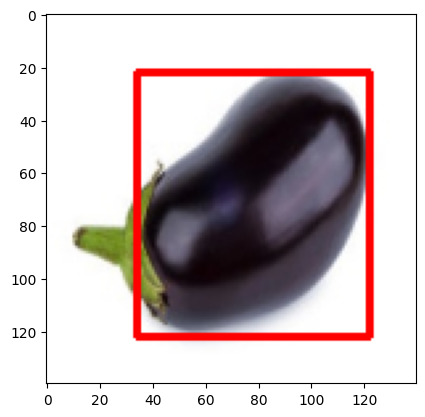

In [35]:
img, bbox = trainset[4]

xmin, ymin, xmax, ymax = bbox

pt1 = (int(xmin), int(ymin))
pt2 = (int(xmax), int(ymax))

bnd_img = cv2.rectangle(img.permute(1, 2, 0).numpy(),pt1, pt2,(255,0,0),2)
plt.imshow(bnd_img)

# Load dataset into batches

In [36]:
trainloader =torch.utils.data.DataLoader(trainset, batch_size= BATCH_SIZE, shuffle=True)
validloader =torch.utils.data.DataLoader(validset, batch_size= BATCH_SIZE, shuffle=False)


In [37]:
print("Total no. batches in trainloader : {}".format(len(trainloader)))
print("Total no. batches in validloader : {}".format(len(validloader)))

Total no. batches in trainloader : 10
Total no. batches in validloader : 3


In [38]:
for images, bboxes in trainloader:
  break;


print("Shape of one batch images : {}".format(images.shape))
print("Shape of one batch bboxes : {}".format(bboxes.shape))

Shape of one batch images : torch.Size([16, 3, 140, 140])
Shape of one batch bboxes : torch.Size([16, 4])


# Create Model

In [39]:
from torch import nn 
import timm

In [40]:
class ObjLocModel(nn.Module):

  def __init__(self):
    super(ObjLocModel, self).__init__()

    self.backbone=timm.create_model(MODEL_NAME,pretrained =True, num_classes =4)


  def forward(self, images, gt_bboxes=None):

    bboxes =self.backbone(images)

    if gt_bboxes !=None:
      loss = nn.MSELoss()(bboxes, gt_bboxes)
      return bboxes, loss

    return bboxes


In [41]:
model =ObjLocModel()
model.to(DEVICE)#if you put ';' architecture wont be shown

Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-weights/efficientnet_b0_ra-3dd342df.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_ra-3dd342df.pth


ObjLocModel(
  (backbone): EfficientNet(
    (conv_stem): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn1): BatchNormAct2d(
      32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
      (drop): Identity()
      (act): SiLU(inplace=True)
    )
    (blocks): Sequential(
      (0): Sequential(
        (0): DepthwiseSeparableConv(
          (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (bn1): BatchNormAct2d(
            32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
            (drop): Identity()
            (act): SiLU(inplace=True)
          )
          (se): SqueezeExcite(
            (conv_reduce): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (act1): SiLU(inplace=True)
            (conv_expand): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (gate): Sigmoid()
          )
          (conv_pw): Conv2d(32, 16, kernel_size=(

In [42]:
random_img = torch.rand(1,3,140,140).to(DEVICE)
model(random_img).shape

torch.Size([1, 4])

# Create Train and Eval Function

In [43]:
def train_fn(model, dataloader, optimizer):
  total_loss=0.0
  model.train()#Dropout ON

  for data in tqdm(dataloader):

    images, gt_bboxes =data
    images, gt_bboxes =images.to(DEVICE), gt_bboxes.to(DEVICE)

    bboxes, loss= model(images, gt_bboxes)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    total_loss +=loss.item()

  return total_loss/ len(dataloader)

In [44]:
def eval_fn(model, dataloader):
  total_loss=0.0
  model.eval()#Dropout OFF

  with torch.no_grad():
      for data in tqdm(dataloader):

          images, gt_bboxes =data
          images, gt_bboxes =images.to(DEVICE), gt_bboxes.to(DEVICE)

          bboxes, loss= model(images, gt_bboxes)


          total_loss +=loss.item()

  return total_loss/ len(dataloader)

#Training Loop

In [45]:
optimizer = torch.optim.Adam(model.parameters(), lr= LR)

In [46]:
best_valid_loss=np.Inf

for i in range(EPOCHS):

  train_loss = train_fn(model, trainloader, optimizer)
  valid_loss =eval_fn(model,validloader)

  if valid_loss < best_valid_loss:
    torch.save(model.state_dict(), 'best_model.pt')
    print('WEIGHTS_ARE_SAVED')
    best_valid_loss = valid_loss

  print(f"Epoch :{i +1} tarin loss :{train_loss} valid loss:{valid_loss}")

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

WEIGHTS_ARE_SAVED
Epoch :1 tarin loss :5334.837841796875 valid loss:2696.9097493489585


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

WEIGHTS_ARE_SAVED
Epoch :2 tarin loss :1950.5005249023438 valid loss:1358.5821940104167


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

WEIGHTS_ARE_SAVED
Epoch :3 tarin loss :1100.5763061523437 valid loss:372.3938802083333


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

WEIGHTS_ARE_SAVED
Epoch :4 tarin loss :761.2811096191406 valid loss:159.71643575032553


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

WEIGHTS_ARE_SAVED
Epoch :5 tarin loss :570.5973449707031 valid loss:155.54659271240234


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch :6 tarin loss :354.46618194580077 valid loss:192.0352020263672


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch :7 tarin loss :323.83571472167966 valid loss:184.57513427734375


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch :8 tarin loss :239.23125152587892 valid loss:176.67968241373697


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch :9 tarin loss :186.8277801513672 valid loss:183.1413370768229


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

WEIGHTS_ARE_SAVED
Epoch :10 tarin loss :138.1358184814453 valid loss:149.22603607177734


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

WEIGHTS_ARE_SAVED
Epoch :11 tarin loss :116.99902725219727 valid loss:144.2979939778646


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

WEIGHTS_ARE_SAVED
Epoch :12 tarin loss :114.2251823425293 valid loss:140.05752817789713


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

WEIGHTS_ARE_SAVED
Epoch :13 tarin loss :98.6125 valid loss:121.70810445149739


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch :14 tarin loss :109.75335464477538 valid loss:147.01397959391275


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

WEIGHTS_ARE_SAVED
Epoch :15 tarin loss :89.46163864135742 valid loss:101.31827036539714


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

WEIGHTS_ARE_SAVED
Epoch :16 tarin loss :99.6500301361084 valid loss:84.86084238688152


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

WEIGHTS_ARE_SAVED
Epoch :17 tarin loss :77.90738334655762 valid loss:83.80256907145183


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch :18 tarin loss :73.73197517395019 valid loss:94.07784016927083


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch :19 tarin loss :64.52031898498535 valid loss:107.00608825683594


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch :20 tarin loss :67.74652442932128 valid loss:90.09566752115886


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch :21 tarin loss :64.47414321899414 valid loss:93.91150410970052


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

WEIGHTS_ARE_SAVED
Epoch :22 tarin loss :48.44393615722656 valid loss:72.6974385579427


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch :23 tarin loss :61.99330883026123 valid loss:86.28643544514973


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

WEIGHTS_ARE_SAVED
Epoch :24 tarin loss :63.097831916809085 valid loss:72.11441802978516


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch :25 tarin loss :50.95122718811035 valid loss:72.22275161743164


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch :26 tarin loss :49.063795471191405 valid loss:73.13079198201497


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch :27 tarin loss :52.244798278808595 valid loss:92.9003194173177


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch :28 tarin loss :42.41873073577881 valid loss:86.77568944295247


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch :29 tarin loss :32.66720495223999 valid loss:89.9338607788086


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch :30 tarin loss :45.2741792678833 valid loss:90.27037556966145


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch :31 tarin loss :50.5874044418335 valid loss:111.8365961710612


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch :32 tarin loss :61.769198989868165 valid loss:90.58637237548828


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

WEIGHTS_ARE_SAVED
Epoch :33 tarin loss :35.54250059127808 valid loss:69.94081497192383


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

WEIGHTS_ARE_SAVED
Epoch :34 tarin loss :67.91604156494141 valid loss:60.3197275797526


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch :35 tarin loss :67.4571605682373 valid loss:83.30706532796223


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch :36 tarin loss :48.75179386138916 valid loss:98.6042874654134


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch :37 tarin loss :42.66225051879883 valid loss:102.10926564534505


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch :38 tarin loss :41.00332508087158 valid loss:79.01073710123698


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch :39 tarin loss :41.822708702087404 valid loss:85.4493014017741


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch :40 tarin loss :55.842735290527344 valid loss:111.93645477294922


#Inference

In [47]:
import utils

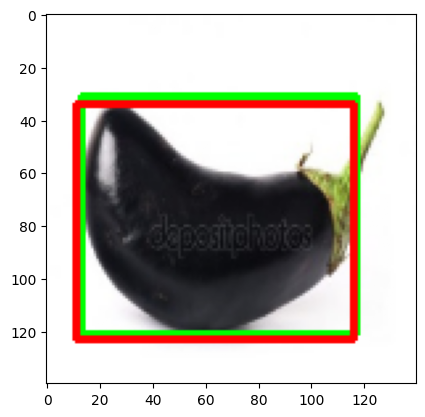

In [49]:
model.load_state_dict(torch.load('best_model.pt'))
model.eval()

with torch.no_grad():

  image, gt_bbox =validset[6]#(c,h,w)
  image=image.unsqueeze(0).to(DEVICE)#(bs,c,h,w)
  out_bbox = model(image)

  utils.compare_plots(image, gt_bbox, out_bbox)

# For updates about upcoming and current guided projects follow me on...

Twitter : @parth_AI

Linkedin : www.linkedin.com/in/pdhameliya